# Exercise 1.4.2 - Building Custom CNNs
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Use the TensorFlow Keras [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to create a convolutional neural network ([CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network));
* Implement the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) CNN architecture;
* Train the LeNet-5 on the modified [MNIST digits](http://yann.lecun.com/exdb/mnist/) dataset;
* Train a CNN model (e.g., LeNet-5) on the German Traffic Sign Recognition Benchmark [GTSRB](https://benchmark.ini.rub.de/gtsrb_dataset.html) dataset.

## 1. Introduction

In [1]:
### Importing the required modules

In [2]:
from collections import defaultdict
import logging
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Generator, Iterator, List, Tuple

In [3]:
tf.__version__

'2.8.2'

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
### Setting the environment variables

In [6]:
ENV_COLAB = True                # True if running in Google Colab instance

In [7]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [8]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [9]:
### Unzipping the GTSRB dataset
!unzip -q /content/GTSRB.zip -d /content/data/

In [10]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Convolutional Neural Networks (CNNs)

#### Background

A [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) ("ConvNet") is a special type of neural network particularly well-suited to handle image data. Like the feedforward neural networks we saw in [Exercise 1.3.3](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-3-3-Image-Classification-FNNs/2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb), CNNs are composed of layers of neurons that have trainable weights and biases. In addition, CNNs often use activation functions and fully-connected layers similar to FNNs (e.g., softmax).

With CNNs, we make the assumption that we will always be using image data as our inputs. Since image data is multi-dimensional, resizing these $\left[H, W, D\right]$ arrays to flattened $\left[1x\left(H*W*D\right)\right]$ vectors is necessary when using fully-connected layers, such as in feedforward neural networks. With ConvNets, however, we make use of locally-connected layers that operate over small portions of _volumetric data_. That is, ConvNets allow us to preserve the existing structure of image data and drastically reduce the amount of trainable parameters needed in each layer of our network. For example, a single fully-connected neuron will require a number of weight values equal to the number of attributes in our image input. For an image of size $\left[64, 64, 3\right]$, we obtain $(64*64*3) = 12288$ weight values _per neuron_. For a layer with only $n = 10$ fully-connected neurons, the number of trainable weights we have skyrockets to an astonishing $n * 12288 = 122880$ parameters per layer. We will see in this exercise that by limiting the connectivity of neurons between layers, we can design a network that reduces the number of parameters required while simultaneously _increasing_ the number of layers in the architecture.

![Fig. 1. The convolutional neural network architecture (simplified).](figures/2022-09-12-Figure-1-Convolutional-Neural-Network-Simplified.png)

$$
\textrm{Fig. 1. The convolutional neural network architecture (simplified)}.
$$

#### Layers

Most, if not all, convolutional neural network architectures use some combination of the following three distinct layer types: _convolutional layer_, _pooling layer_, and _fully-connected layer_. We have implemented fully-connected layers in [Exercise 1.3.3](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-3-3-Image-Classification-FNNs/2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb) for feedforward neural networks, and their application in ConvNets is no different. However, we introduce the _convolutional layer_ in this exercise. We will touch on these in more detail in just a minute.

##### Input layer

It is important to first note that our _input layer_ corresponds directly to the dimensionality of our image data. One major assumption we make with convolutional neural networks is that our input image dimensions are constant. That is, that every image passing through our network shares the same _height_, _width_, and _channel_ dimensions. In ConvNets, the _depth_ of an image (its colour channels, e.g., R, G, B) is maintained throughout the network while the height and width might change. For convolutional and pooling layers, this matters because each kernel and filter will require an extra dimension $D$ equal to the number of colour channels in an image in addition to their width and height attributes. For an RGB image, a kernel/filter of size $\left(h \ x \ w\right)$ will therefore have dimensions $\left(h \ x \ w \ x \ 3\right)$.

##### Convolutional layer

Very similar to the pooling layers we studied in [Exercise 1.4.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-4-1-Pooling-Layers-CNNs/2022-09-07-Pooling-Layers-Convolutional-Neural-Networks.ipynb), these layers take an input, the volumetric image data, and perform sliding window operations ([convolutions](https://en.wikipedia.org/wiki/Convolution)) over the image. The convolution layer, like pooling layers, have _stride_, _kernel size_ and _padding_ attributes. We also introduce a _filter_ hyperparameter which allows us to specify the desired dimensionality of our convolution layer output. Convolutional layers rarely ever have just _one filter_. In fact, it is very common to see a single convolutional layer have anywhere from 32 filters up to 512. Each _filter_ represents a _feature_ in the input image (hence the output name "feature map"). These filters are templates which, when convolved with an input image, help locate and identify vertical, horizontal edges, arches, diagonal lines, etc.

The convolutional layer in a network is often directly followed by an element-wise activation layer such as the Rectified Linear Unit ([ReLU](https://en.wikipedia.org/wiki/Rectifier_\(neural_networks\))) to introduce further non-linearities into the network. Note that the activation layer's output dimensions remain constant.

##### Pooling layer

Pooling layers, as mentioned in the previous Exercise 1.4.1, reduce the size (spatial dimensions) of the images through a downsampling (averaging) or sub-sampling (max/min) operation. By replacing adjacent pixel values with neighbourhood calculations we are able to transform the output and effectively manipulate (increase _multiplicatively_) the [receptive field](https://en.wikipedia.org/wiki/Receptive_field#In_the_context_of_neural_networks) of the image (i.e., the region within an image of which a particular neuron is sensitive to). On the other hand, convolutional layers increase the receptive field _linearly_ proportional to the kernel size. Cascading convolutional layers with _dialated filters_ increase the receptive field exponentially [1]. By shrinking the image, we are essentially _increasing_ the amount of its pixels (information) we can fit into a single "patch" for a neuron to consider.

As the image becomes reduced in size as it passes through the network, neurons in deeper layers get to "see" larger and larger parts of the whole image. In turn, we can increase the receptive field of a network exponentially while increasing the number of parameters linearly. This trade-off is what affords us the ability to swap only a few fully-connected layers for _handfuls_ of convolutional stacks without increasing complexity or decreasing the receptive field.

##### Fully-connected layer

While we aren't able to eliminate fully-connected layers altogether, their use in convolutional neural networks is limited. Fully-connected layers appear at the end of a network for classification; the number of neurons of the last fully-connected layer in a CNN equal the number of distinct classes predicted (e.g., there are $3$ distinct classes being predicted in the example shown in Fig. 1). Practitioners may also choose to implement several preceding fully-connected layers with an arbitrarily large number of neurons, e.g., 512, 256, 64.

#### In summary
   * Inputs to a ConvNet are volumetric image data with fixed dimensions;
   * We use pooling layers to _downsample_ or _sub-sample_ images (reduce their spatial dimensions);
   * By reducing the spatial dimensions, we _increase_ the neurons' receptive fields (how much of the image they can "see");
   * With convolutional networks we are able to eventually cover the entire region of an input image at a cost significantly reduced to fully-connected layers;

We have now learned the benefits of convolutional architectures to more-traditional neural networks (specifically, feedforward neural networks); by adding "stacks" of convolutional/pooling layers, we can exploit the complexity-efficiency trade-off. Convolutional stacks help us set reasonable limits on neural network complexity by decreasing the number of overall trainable parameters we have to work with layer-for-layer. This not only improves training efficiency but also helps boost performance on image classification tasks.

While popular CNN architectures often make use of even more efficiency-focused layers, such as _dropout_/_inverted dropout_, _skip connections_, and _batch normalisation_, we will limit our discussion on those topics for now.

### 1.2. LeNet

#### Background

![Fig. 2. The LeNet-5 convolutional neural network architecture for digits recognition.](figures/2022-09-12-Figure-2-LeNet-5-CNN-Architecture.png)

$$
\textrm{Fig. 2. The LeNet-5 convolutional neural network architecture for digits recognition (proposed in LeCun 1998:7).}
$$

The [LeNet-5](https://en.wikipedia.org/wiki/LeNet) is a convolutional neural network architecture proposed by Yann LeCun et al. of Bell Labs in 1998 [2]. LeNet-5 is recognised in the deep learning community as being one of the earliest ConvNet architectures with work dating back to [1989](https://doi.org/10.1162%2Fneco.1989.1.4.541). LeCun's model (illustrated in Fig. 2) has all the basic units of a convolutional neural network: convolutional layers, pooling layers and fully-connected layers. Like most ConvNet architectures we studied, the LeNet-5 has alternating convolutional and sub-sampling (average pooling) layers. Also as expected we see that the number of filters/kernel windows increases as we go deeper in the network, starting with $6$ and increasing to $16$ in the final convolutional layer. In Fig. 2, we can interpret the number preceeding the "@" symbol as the number of filters/kernels of each layer, followed by the filter/kernel size (omitting the _depth_ dimension from the notation). Lastly, we have for each layer in the convolutional stack a _stride_ hyperparameter denoted by $s$.

Not shown in Fig. 2 is the use of the [tanh](https://paperswithcode.com/method/tanh-activation) non-linear activation function throughout the network. While this proved to be a better performer than the sigmoid function for a multi-layer neural network, _tanh_ did not appropriately handle the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), architectures today utilise other activation functions such as [ReLU](https://en.wikipedia.org/wiki/ReLU) or [batch normalisation](https://en.wikipedia.org/wiki/Batch_normalization) to solve this. The last layer of the network utilises a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function to fit a Gaussian distribution to the predicted class probabilities.

#### Layers

##### Input layer

The input to the LeNet-5 network is a set of $\left(32 \ x \ 32 \ x \ 1\right)$ grayscale images, each consisting of a single handwritten digit (read more on the modified MNIST SD-1/SD-3 dataset [here](http://yann.lecun.com/exdb/mnist/)). The pixel values of the input images are normalised (anti-aliasing) so that the background (white) has a pixel value of $-0.1$ and the foreground (black) has a value $1.175$. This choice for normalisation is made such that the mean value of the input is roughly $0$ and the variance roughly $1$ to accelerate learning.

##### Convolutional layer (C1)

* **Input size**: $32 x 32 x 1$
* **Feature maps**: $6$
* **Kernel size**: $5x5x1$
* **Stride**: $1$
* **Padding**: $0$
* **Output size**: $(28x28x1)$; $(32 - 5 + 2*0) \ / \ 1 + 1 = 28$
* **Neurons**: $6 * (28x28x1) = 4704$
* **Trainable parameters**: $6 * (5x5x1 + 1) = 156$
* **Total connections**: $6 * (5x5x1 + 1) * (28x28) = 122304$
* **Activation function**: Tanh

This convolutional layer has $6$ feature maps. Each unit of each feature map connects to a $5 x 5$ region within the input image. The feature map size of $28 x 28$ has been selected so that the strided convolutions do not result in any dropped pixels (for more information on that, see [Exercise 1.4.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-4-1-Pooling-Layers-CNNs/2022-09-07-Pooling-Layers-Convolutional-Neural-Networks.ipynb)). each kernel has an additional bias term (hence the "+1" in the above calculation of trainable parameters. While the number of connections seems tremendous, due to _weight sharing_ we only need to learn $156$ parameters for this layer.

##### Average pooling layer (S2)

* **Input size**: $28 x 28 x 1$
* **Feature maps**: $6$
* **Filter size**: $2x2x1$
* **Stride**: $2$
* **Padding**: $0$
* **Output size**: $(14x14x1)$; $(28 - 2 + 2*0) \ / \ 2 + 1 = 14$
* **Neurons**: $6 * (14x14x1) = 1176$
* **Trainable parameters**: $6 * (1 + 1) = 12$
* **Total connections**: $6 * (2x2x1 + 1) * (14x14x1) = 5880$
* **Activation function**: Tanh

This sub-sampling layer uses the local average pooling calculations to reduce the input size in half from $28x28$ to $14x14$. Each window of values is summed, multiplied by a weight coefficient $w$ and then added together with a trainable bias offset term $b$ (hence the number of trainable parameters shown above). These parameters are learned with [back-propagation](https://en.wikipedia.org/wiki/Backpropagation). The intermediate output values are then passed into a sigmoid activation function which is used to enforce non-linearity. The coefficient and bias terms regulate the intensity of the sigmoid function on the output. If the coefficient values are small, then the units operate in a quasi-linear mode such that the sub-sampling layer merely blurs the input. If the coefficient is large, sub-sampling performs similarly to a "noisy OR", "noisy AND" function depending on the value of the bias (LeCun 1998).

The affect of downsampling of the input is a reduction in sensitivity of the output to shifts and distortions. By progressively reducing the spatial resolution with sub-sampling, we compensate the effect by progressively increasing the number of feature maps (the richness of the representation).

##### Convolutional layer (C3)

* **Input size**: $14 x 14 x 1$
* **Feature maps**: $16$
* **Kernel size**: $5 x 5 x 1$
* **Stride**: $1$
* **Padding**: $0$
* **Output size**: $(10x10x1)$; $(14 - 5 + 2*0) \ / \ 1 + 1 = 10$
* **Neurons**: $16 * (10x10x1) = 1600$
* **Trainable parameters**: $6 * \left[(3x5x5 + 1) + (4x5x5 + 1)\right] + 3*\left[(4x5x5 + 1)\right] + 1*\left[(6x5x5 + 1)\right] = 1516$
* **Total connections**: $1516*(10x10x1) = 151600$
* **Activation function**: Tanh

In this second convolutional layer, we increase the number of feature maps to $16$. In conjunction with the progressive decrease in spatial dimensions of the input images, we now _increase_ the richness of the representation of the input by increasing the number of feature maps. With the increase in feature maps brings a non-complete connection scheme in order to keep the number of connections of $S2$ and $C3$ within resonable bounds.

![Fig. 3. The non-complete connection scheme for layers S2 and C3 (reproduced from LeCun et al., 1998)](figures/2022-09-12-Figure-3-Table-1-LeCun-1998.png)

$$
\textrm{Fig. 3. The non-complete connection scheme for layers} \ S2  \ \textrm{and} \  C3  \ \textrm{(reproduced from LeCun et al., 1998)}
$$

From the _total connections_ calculation above we see that the first _six_ feature maps of $C3$ take inputs from every contiguous subset of _three_ feature maps of $S2$. The next _six_ feature maps of $C3$ take inputs from every contiguous subset of _four_ feature maps of $S2$. The following _three_ feature maps of $C3$ take inputs from _discontinuous_ subsets of _four_ feature maps of $S2$. The last feature map ($1$) takes _all six_ inputs of the feature maps of $S2$.

With that, we calculate the total number of trainable parameters of $C3$ equal to $1516$ and the number of total connections equal to $151600$.

##### Average Pooling layer (S4)

* **Input size**: $10 x 10 x 1$
* **Feature maps**: $16$
* **Filter size**: $2x2x1$
* **Stride**: $2$
* **Padding**: $0$
* **Output size**: $(5x5x1)$; $(10 - 2 + 2*0) \ / \ 2 + 1 = 5$
* **Neurons**: $16 * (5x5x1) = 400$
* **Trainable parameters**: $16 * (1 + 1) = 32$
* **Total connections**: $16 * (2x2x1 + 1) * (5x5x1) = 2000$
* **Activation function**: Tanh

The down-sampling layer $S4$ reduces its input by a factor of 2 from $10x10x1$ down to $5x5x1$. The $16$ feature maps of size $10x10x1$ from $C3$ are pooled into $2x2x1$ units to obtain $16$ feature maps of size $5x5x1$.  

##### Convolutional layer (C5)

* **Input size**: $5 x 5 x 1$
* **Feature maps**: $120$
* **Kernel size**: $5 x 5 x 1$
* **Stride**: $1$
* **Padding**: $0$
* **Output size**: $(1x1x1)$; $(5 - 5 + 2*0) \ / \ 1 + 1 = 1$
* **Neurons**: $120 * (1x1x1) = 120$
* **Trainable parameters**: $120 * (16x5x5x1 + 1) = 48120$
* **Total connections**: $120 * (16x5x5x1) = 48000$
* **Activation function**: Tanh

Here the final convolutional layer $C5$ is considered to be fully-connected with respect to the input dimensionality of the digits images. For any other configuration (i.e., an increase in the number of channels, as with RGB images), we can expect this to be explicitly a convolutional layer. For the digits dataset, given a kernel size of $5x5x1$ and a corresponding output of layer $S4$ of size $5x5x1$, we obtain a fully-connected layer with $(1x1x1)$ feature map output dimensions. Therefore, we have $48120$ trainable parameters and $48000$ total connections in this last convolutional layer.  

##### Fully-connected layer (F6)

* **Input size**: $1 x 1 x 1$
* **Feature maps**: N/A
* **Kernel size**: N/A
* **Stride**: N/A
* **Padding**: N/A
* **Output size**: $(1x1)$
* **Neurons**: $84 * (1x1x1) = 84$
* **Trainable parameters**: $84*(120x1x1 + 1) = 10164$
* **Total connections**: $120 * (16x5x5x1) = 48000$
* **Activation function**: Tanh

The second-to-last layer in the LeNet-5 network is fully-connected to the convolutional layer $C5$; we can consider $F6$ to be a true fully-connected layer with $84$ units. Here the number of units for this layer was selected according to a $7x12$ bitmap representation corresponding to one of the $10$ character classes. This is considering that the representation used is not particularly useful for _isolated_ digits but rather _strings_ of characters selected from the printable ASCII set which tends to produce _confusable_ i.e., different characters with similar appearances (e.g., an upper/lower-case "O" and a zero, or an uppercase "I" and the digit 1).

##### Output layer (OUTPUT or F7)

* **Classes**: 10
* **Output size**: $(10x1)$
* **Neurons**: $84 * (1x1x1) = 84$
* **Trainable parameters**: $84*(10x1x1 + 0) = 840$
* **Total connections**: $10 * (84x1x1x1) = 840$
* **Activation function**: RBF

The final layer in the LeNet-5 is of course the classification output layer — a fully-connected layer composed of Euclidean Radial Basis Function units (RBF). There are 10 RBF units, one for each digit class, each with a set of 84 inputs. The output of each RBF unit is computed with a Euclidean distance summation between its input vector and its parameter vector. The Euclidean distance (L2 loss) serves as a penalty for the input and RBF digit class; the larger the RBF output, the farther away the input is from the parameter vector. The choice of L2 loss here greatly penalises outliers (distance "away" from parameter vectors). The RBF output can also be interpreted as the un-normalised negative log-likelihood of the Gaussian distribution of $F6$.

In short, the parameter vectors of the RBF units act as target vectors for the $F6$ layer. The components of the parameter vectors are valued $+1$ or $-1$, which are points along the maximum curvature of the scaled _hyperbolic tangent_, i.e., [tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions#Hyperbolic_tangent), or in other words — the re-scaled and shifted sigmoid activation function. Therefore, the RBF activation function is chosen for this output layer to enforce the maximally non-linear range of the tanh function applied to units in $F6$.

#### Reflecting on the LeNet-5

##### Activation functions

The tanh and sigmoid activation functions used in LeNet-5 have their downsides. As pointed out in the original paper by LeCun et al., 1998, the scaled tanh function presents issues with saturation at the maximum and minimum boundary points. This leads to [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) as the derivatives of the function approach zero. Since we have a handful of hidden layers, the multiplication of these near-zero gradient values results in an exponential decrease in the gradient as it is propagated from the final to the initial layer.

ReLu or Leaky ReLu are more often used nowadays to address this. ReLU imposes a lower-bound for gradient values at $0$. This handles the vanishing gradient problem by eliminating saturation at very small gradient values — their values simply become zero, ultimately encourages sparsity in the learned representations [3]. Yet in some cases, ReLU may end up always returning the lower-bound ($0$) for any input. The [dying ReLU problem](https://www.educative.io/answers/what-is-the-dying-relu-problem) is the result of zero-valued gradient propagations and a high learning rate or a large negative bias could be at fault. To mitigate this, the [Leaky ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) is used which does not produce zero-valued gradients.

## 2. Programming Task

Using the Keras API, you have to create a small convolutional neural networks using less than 15 layers, containing at least one convolutional layer, one pooling layer and one dense (fully connected layer). You can find a list of the different layers available [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

In [11]:
model_params = defaultdict(dict)

### 2.1. LeNet-5

#### Defining the model architecture

In [12]:
### From Udacity's `training.py`

In [13]:
def create_lenet_network(input_shape: Tuple[int], 
                         output_shape: int) -> tf.keras.Sequential:
    """Creates the LeNet-5 network (LeCun et al., 1998).
    
    :param input_shape: tuple, the n-dimensional shape of the input images.
    :param: output_shape: tuple, the 1D shape corresponding to number of
        distinct classes to predict.
    :returns: the LeNet-5 Model object.
    """
    # IMPLEMENT THIS FUNCTION
    
    model = tf.keras.Sequential(layers=[
        # The C1 (convolutional) layer
        tf.keras.layers.Conv2D(
                input_shape=input_shape,    # Shape of the input images
                filters=6, 
                kernel_size=(5, 5), 
                strides=(1, 1), 
                padding='valid',            # No padding
                activation='tanh',
                name='C1'
        ),
        # The S2 (sub-sampling) layer
        tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='valid',
                name='S2'
        ),
        tf.keras.layers.Activation(
                activation=tf.keras.activations.sigmoid,
                name='Sigmoid_1'
        ),
        # The C3 (convolutional) layer
        tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=(5, 5),
                strides=(1, 1),
                padding='valid',
                activation='tanh',
                name='C3'
        ),
        # The S4 (sub-sampling) layer
        tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='valid',
                name='S4'
        ),
        tf.keras.layers.Activation(
                activation=tf.keras.activations.sigmoid,
                name='Sigmoid_2'
        ),
        # The C5 (convolutional) layer
        tf.keras.layers.Conv2D(
                filters=120,
                kernel_size=(5, 5),
                strides=(1, 1),
                padding='valid',
                activation='tanh',
                name='C5'
        ),
        # The Flatten layer
        tf.keras.layers.Flatten(),
        # The F6 (fully-connected) layer
        tf.keras.layers.Dense(
                units=84,
                activation='tanh',
                name='F6'
        ),
        # The F7 (Output) layer
        tf.keras.layers.Dense(
                units=output_shape,
                activation='softmax',
                name='Output'
        )
    ], name=MODEL_NAME)
    return model

#### Defining the model build parameters

In [13]:
### Defining our model parameters

In [14]:
model_name = 'LeNet-5'
optimizer = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

In [15]:
model_params[model_name].update({'optimizer': optimizer})
model_params[model_name].update({'loss_fn': loss})
model_params[model_name].update({'metrics': metrics})

### 2.2. Custom CNN

You should experiment with different designs (number of layers, types of pooling, filter sizes, number of fully connected layers, number of neurons).

The following Custom CNN architecture was adapted from Zaibi et al., 2021 [4], a lightweight CNN architecture inspired by the LeNet-5. This model has demonstrated success on the German Traffic Sign Recognition Benchmark (GTSRB) dataset and was selected for its lightweight architecture which can be trained on a CPU in a very short amount of time (under 2 minutes on this Google Colab instance).

#### Defining the model architecture

In [16]:
### From Udacity's `training.py`

In [190]:
def create_custom_network(
    input_shape: Tuple[int], output_shape: int, model_name: str='CustomModel'
)-> tf.keras.Sequential:
    """Creates a modified LeNet-5 network (Zaibi et al., 2021).
    
    :param input_shape: tuple, the n-dimensional shape of the input images.
    :param: output_shape: tuple, the 1D shape corresponding to number of
        distinct classes to predict.
    :returns: the modified LeNet-5 Model object.
    """
    # IMPLEMENT THIS FUNCTION
    
    model = tf.keras.Sequential(layers=[
        # The R0 (Reshape) layer
        tf.keras.layers.Reshape(
                target_shape=input_shape,
                name='R0'
        ),
        # The Rs0 (Rescaling) layer
        tf.keras.layers.Rescaling(
                scale=1./255,                # Rescales to [0, 1]
                name='Rs0'
        ),
        # The C1 (convolutional) layer
        tf.keras.layers.Conv1D(
                filters=60, 
                kernel_size=(5,), 
                strides=(1,), 
                padding='valid',
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name='C1'
        ),
        # The C2 (convolutional) layer
        tf.keras.layers.Conv1D(
                filters=60, 
                kernel_size=(5,), 
                strides=(1,), 
                padding='valid',
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name='C2'
        ),
        # The Bn3 (Batch Normalization) layer
        tf.keras.layers.BatchNormalization(
                name='Bn3'
        ),
        # The M4 (Max Pooling) layer
        tf.keras.layers.MaxPool1D(
                pool_size=(2,),
                strides=(2,),
                padding='valid',
                name='M4'
        ),
        # The C5 (convolutional) layer
        tf.keras.layers.Conv1D(
                filters=30, 
                kernel_size=(3,), 
                strides=(1,), 
                padding='valid',
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name='C5'
        ),
        # The C6 (convolutional) layer
        tf.keras.layers.Conv1D(
                filters=30, 
                kernel_size=(3,), 
                strides=(1,), 
                padding='valid',
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name='C6'
        ),
        # The M7 (Max Pooling) layer
        tf.keras.layers.MaxPool1D(
                pool_size=(2,),
                strides=(2,),
                padding='valid',
                name='M7'
        ),
        # The D8 (Dropout regularization) layer
        tf.keras.layers.Dropout(
                rate=0.5,
                name='D8'
        ),
        # The Flatten layer
        tf.keras.layers.Flatten(),
        # The F9 (fully-connected) layer
        tf.keras.layers.Dense(
                units=500,
                activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                name='F9'
        ),
        # The Bn10 (Batch Normalization) layer
        tf.keras.layers.BatchNormalization(
                name='Bn10'
        ),
        # The D11 (Dropout regularization) layer
        tf.keras.layers.Dropout(
                rate=0.5,
                name='D11'
        ),
        # The F12 (Output) layer
        tf.keras.layers.Dense(
                units=output_shape,
                activation='softmax',
                name='Output'
        )
    ], name=model_name)
    return model

#### Defining the model build parameters

In [18]:
model_name = 'Custom_LeNet-5'
optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

In [19]:
model_params[model_name].update({'optimizer': optimizer})
model_params[model_name].update({'loss_fn': loss})
model_params[model_name].update({'metrics': metrics})

### 2.3. Training and validation

The following helper functions are used for the training and validation loops.

In [16]:
### From Udacity's `utils.py`

In [17]:
def get_module_logger(mod_name: str) -> logging.Logger:
    """Initialises a console logger instance.
    
    :param mod_name: the model name to assign to the logger.
    :returns: a logger instance.
    """
    
    ### Setting up the console logger and formatter
    logger = logging.getLogger(mod_name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.DEBUG)
    ### Prevent messages going to root handler
    logger.propagate = False
    return logger

In [18]:
def display_metrics(history: tf.keras.callbacks.History):
    """Plots the per-epoch loss and accuracy metrics.
    
    :param history: the Keras `callbacks.History` object.
    """
    
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], linewidth=3)
    ax[0].plot(history.history['val_loss'], linewidth=3)
    ax[0].set_title('Loss', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].legend(['train loss', 'val loss'], loc='upper right')
    ax[1].plot(history.history['accuracy'], linewidth=3)
    ax[1].plot(history.history['val_accuracy'], linewidth=3)
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[1].legend(['train acc', 'val acc'], loc='upper left')
    plt.show()

### 2.3. Evaluation on the modified MNIST digits dataset

In [19]:
DATASET_NAME = 'MNIST'

#### Fetching the modified MNIST data

In [20]:
### Specifying the validation/test split percentages
VAL_PERCENT = 25
TEST_PERCENT = 75

In [21]:
### Specifying the desired batch size
BATCH_SIZE = 128
model_params[DATASET_NAME].update({'batch_size': BATCH_SIZE})

In [22]:
### Fetching the MNIST digits dataset (hosted by TensorFlow)
# See: https://www.tensorflow.org/datasets/catalog/mnist

In [23]:
digits_data, digits_info = tfds.load(DATASET_NAME,
                                     batch_size=BATCH_SIZE,
                                     split=['train', 
                                            'test[{}%:]'.format(VAL_PERCENT),
                                            'test[:{}%]'.format(TEST_PERCENT)
                                     ],
                                     shuffle_files=True, 
                                     with_info=True
)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


#### Considerations for our input data

In [24]:
### Viewing the dataset metadata attributes
digits_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [25]:
# MNIST has 10 distinct digit classes
N_CLASSES = digits_info.features['label'].num_classes
print('Nr. classes in MNIST:', N_CLASSES)

Nr. classes in MNIST: 10


In [26]:
### Fetching our input image specs

In [27]:
IMG_COLOR_MODE = 'grayscale'
IMG_SHAPE = digits_info.features['image'].shape
IMG_SIZE = IMG_SHAPE[:2]

In [28]:
print('MNIST:', digits_info.features['image'])

MNIST: Image(shape=(28, 28, 1), dtype=tf.uint8)


**Note**: the LeNet-5 network expects $32x32$ px grayscale images as input. We will fix this by padding our images to the expected size.

In [29]:
model_params[DATASET_NAME].update({'image_size': IMG_SIZE})
model_params[DATASET_NAME].update({'color_mode': IMG_COLOR_MODE})
model_params[DATASET_NAME].update({'input_shape': IMG_SHAPE})
model_params[DATASET_NAME].update({'n_classes': N_CLASSES})

#### Processing the image data

In [30]:
### Number of features (pixel values) in a single image
len(iter(digits_data[0]).get_next()['image'][0].numpy().flatten())

784

##### Defining the preprocessing functions

In [31]:
### From J. Moran's `2022-09-07-Pooling-Layers-Convolutional-Neural-Networks.ipynb`

In [32]:
def get_paddings(input_tensor: tf.Tensor, output_shape: Tuple[int, int, int], 
                 pool_size: int, pool_stride: int) -> List[List[int]]:
    """Returns the range of values to pad on each edge using TensorFlow.
    
    Computes the padding amounts along each dimension such that the
    spatial dimensionality of the input is preserved (akin to the
    TensorFlow Keras `padding="same"` argument). Note that the input
    is a 4-dimensional array but we computing only the padding amounts 
    for the 2D image surface (the width and height axes).

    For more information on the TensorFlow `pad()` function, see:
    https://www.tensorflow.org/api_docs/python/tf/pad
    
    :param array: tf.Tensor, the input data of dimensions [NxWxHxC], 
        i.e., [n_samples x width x height x n_channels].
    :param pool_size: int, the symmetric kernel window dimension.
    :param pool_stride: int, the amount to displace the kernel window
        in the horizontal and vertical direction (symmetric).
    :returns: paddings, the TensorFlow `paddings` padding sequences.
    """
    
    wpad = None
    hpad = None
    # Get the per-sample input dimensions
    _, w, h, _ = tf.shape(input_tensor).numpy()
    # Set the desired output shape
    _, w_out, h_out, _ = output_shape
    # Compute the padding dimensions
    wpad = (pool_stride * w_out - w + pool_size - pool_stride) // 2
    hpad = (pool_stride * h_out - h + pool_size - pool_stride) // 2
    # Return the range of values to pad along each dimension
    # [n_samples, width, height, n_channels]
    return [[0, 0], [0, wpad], [0, hpad], [0, 0]]

In [33]:
### From J. Moran's `2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb`

In [34]:
def process(dataset: tf.data.Dataset) -> Generator[tuple, None, None]:
    """Processes the input dataset and returns a generator object.

    :param dataset: the tf.data.Dataset instance of batched image, label data.
    :returns: the generator instance modifying the image attribute values.
    """

    def process_generator() -> Iterator[Tuple[tf.Tensor, tf.Tensor]]:
        """Zero-pads and scales the input images.
        
        All images in each batch are padded according to the pre-computed
        pad widths. All pixel values are scaled in the range [0, 1].

        Note that the input dataset is expected to contain images with a 
        consistent (equal) shape, e.g., (28, 28, 1). This function also 
        assumes a zero-padding configuration. If your dataset contains images
        with inconsistent dimensions, and you want to use zero-padding,
        an easier technique is a `tf.bitwise_or` with a zero-valued mask of
        dimensions equal to your desired output dataset.

        :returns: an iterator yielding the modfied images and labels.
        """

        for batch in dataset:
            # Padding the input image to 32x32 resolution
            images = tf.pad(batch['image'],
                            paddings=PADDINGS,
                            mode='CONSTANT',
                            constant_values=tf.constant(
                                value=PADDING_VALUE,
                                dtype=digits_info.features['image'].dtype
                            )
            )
            # Scaling the image data in range [0, 1]
            images = tf.cast(images / 255, 
                             # Casting dtype to float32 after scaling
                             dtype=tf.dtypes.float32
            )
            yield images, batch['label']
    return process_generator

**UPDATE 2022-09-18 09:56 PT**: Here we resolve Issue #[12](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/issues/12) with the above modification to `process` generator. Previously casting images as original `uint8` dtype _after scaling_ which resulted in zero-valued data.

##### Preprocessing the dataset

In [35]:
### Setting the desired shape after padding
IMG_SHAPE_PADDED = (None, 32, 32, 1)

In [36]:
### Computing the padding amounts for each axis
# Assuming our dataset image sizes are consistent
# Here we use the first LeNet-5 layer (C1) parameters

In [37]:
PADDINGS = get_paddings(input_tensor=iter(digits_data[0]).get_next()['image'],
                        output_shape=IMG_SHAPE_PADDED,
                        pool_size=5,
                        pool_stride=1
)
print('Paddings:', PADDINGS)

Paddings: [[0, 0], [0, 4], [0, 4], [0, 0]]


In [38]:
### Setting the scalar value to pad the image arrays with
PADDING_VALUE = 0

In [39]:
### Updating the model parameters

In [40]:
model_params[DATASET_NAME].update({'image_size_padded': IMG_SHAPE_PADDED[:2]})
model_params[DATASET_NAME].update({'input_shape_padded': IMG_SHAPE_PADDED})
model_params[DATASET_NAME].update({'paddings': PADDINGS})
model_params[DATASET_NAME].update({'padding_value': PADDING_VALUE})

In [41]:
### Unpacking the train/validation/test subsets

In [42]:
train_data, val_data, test_data = digits_data

###### Using a generator function

In [43]:
train_dataset_processed = tf.data.Dataset.from_generator(
        generator=process(train_data), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape_padded', None),
                dtype=tf.dtypes.float32
            ), 
            tf.TensorSpec(
                shape=(None, *digits_info.features['label'].shape), 
                dtype=digits_info.features['label'].dtype
            )
        )
)

In [44]:
validation_dataset_processed = tf.data.Dataset.from_generator(
        generator=process(val_data), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape_padded', None),
                dtype=tf.dtypes.float32
            ), 
            tf.TensorSpec(
                shape=(None, *digits_info.features['label'].shape), 
                dtype=digits_info.features['label'].dtype
            )
        )
)

In [45]:
test_dataset_processed = tf.data.Dataset.from_generator(
        generator=process(test_data), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape_padded', None),
                dtype=tf.dtypes.float32
            ), 
            tf.TensorSpec(
                shape=(None, *digits_info.features['label'].shape), 
                dtype=digits_info.features['label'].dtype
            )
        )
)

In [46]:
### Previewing the first scaled and padded image in test set

In [47]:
iter(test_dataset_processed).get_next()[0][0]

<tf.Tensor: shape=(32, 32, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

###### Using TensorFlow `data` operations

So after reading the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) documentation, I'm feeling a bit embarassed to have used an "anti-pattern" to preprocess our data. TensorFlow documentation states that the `Dataset.from_generator()` function uses [`tf.numpy_function`](https://www.tensorflow.org/api_docs/python/tf/numpy_function) behind the scenes, which means that we inherit the performance constraints of `tf.numpy_function`.

Furthermore, TensorFlow docs state that "the scope of `Dataset.from_generator()` should be limited to logic that connot be expressed through `tf.data` operations. Using `tf.data` operations within the generator function is an anti-pattern that may result in incremental memory growth."

Since that's exactly what we're doing above, let's try to utilise those `tf.data` ops to preprocess our dataset.

In [43]:
### Scaling the data using `Dataset.map()` and lambda functions

In [44]:
train_data_scaled = train_data.map(lambda x: x['image'] / 255)
val_data_scaled = val_data.map(lambda x: x['image'] / 255)
test_data_scaled = test_data.map(lambda x: x['image'] / 255)

In [45]:
### Padding the data using `Dataset.map()` and `tf.pad()`

In [46]:
train_data_padded = train_data_scaled.map(lambda x: tf.pad(x, paddings=PADDINGS))
val_data_padded = val_data_scaled.map(lambda x: tf.pad(x, paddings=PADDINGS))
test_data_padded = test_data_scaled.map(lambda x: tf.pad(x, paddings=PADDINGS))

In [47]:
### Fetching the labels in each dataset

In [48]:
train_labels = train_data.map(lambda x: x['label'])
val_labels = val_data.map(lambda x: x['label'])
test_labels = test_data.map(lambda x: x['label'])

In [49]:
### Zipping together the processed data and labels using `Dataset.zip()`

In [50]:
train_data_processed = tf.data.Dataset.zip((train_data_padded, train_labels))
val_data_processed = tf.data.Dataset.zip((val_data_padded, val_labels))
test_data_processed = tf.data.Dataset.zip((test_data_padded, test_labels))

Great! We've moved away from the `from_generator()` anti-pattern with the help of a few `tf.data` operations. For more information on these ops, check out the [`Dataset.map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map), [`tf.math.divide`](https://www.tensorflow.org/api_docs/python/tf/math/divide), [`tf.pad()`](https://www.tensorflow.org/api_docs/python/tf/pad) and [`Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip) documentation.

###### Some performance tests

Even though we'll take TensorFlow's word, I wanted to test the performance of both preprocessing approaches for my given workflow.

In [48]:
### Wrapping the generator calls in a test function

In [49]:
def test_generator(generator_fn, dataset):
    """Simple function using generator to process a dataset."""

    dataset_processed = tf.data.Dataset.from_generator(
            generator=generator_fn(dataset), 
            output_signature=(
                tf.TensorSpec(
                    shape=model_params[DATASET_NAME].get('input_shape_padded', 
                                                         None
                    ),
                    dtype=tf.dtypes.float32
                ), 
                tf.TensorSpec(
                    shape=(None, *digits_info.features['label'].shape), 
                    dtype=digits_info.features['label'].dtype
                )
            )
    )
    # Fetching the first processed element in the dataset
    return iter(dataset_processed).get_next()[0]

In [50]:
### Wrapping the tf.data ops in a test function

In [54]:
def test_data_ops(dataset):
    """Simple function using tf.data ops to process a dataset."""

    ### Scaling the data using `Dataset.map()` and lambda functions
    dataset_scaled = dataset.map(lambda x: x['image'] / 255)
    ### Padding the data using `Dataset.map()` and `tf.pad()`
    dataset_padded = dataset_scaled.map(lambda x: tf.pad(x, paddings=PADDINGS))
    ### Fetching the labels in the dataset
    dataset_labels = dataset.map(lambda x: x['label'])
    ### Zipping together the processed data and labels using `Dataset.zip()`
    dataset_processed = tf.data.Dataset.zip((dataset_padded, dataset_labels))
    ### Fetching the first processed element in the dataset
    return iter(dataset_processed).get_next()[0]

**Note**: I'm not working in a [distributed training](https://www.tensorflow.org/api_docs/python/tf/distribute) environment or dealing with enormous dataset sizes at the moment, so let's just play around and see what we get in terms of execution time...

In [52]:
### Testing the generator approach and averaging its execution time
%timeit test_generator(process, test_data)

70.7 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
### Testing the tf.data ops approach and averaging its execution time
%timeit test_data_ops(test_data)

106 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


From the results above, it might be surprising to see that the `Dataset.from_generator()` (the anti-pattern) approach actually performs **better** than the pure TensorFlow `tf.data` ops approach. A great explanation to understand this can be read on [this](https://github.com/tensorflow/tensorflow/issues/35135#issuecomment-566810134) StackOverflow post. In short, the benefits of `Dataset.map()` are realised when performing non-trivial computation that can benefit from either the behind-the-scenes [`tf.Graph`](https://www.tensorflow.org/api_docs/python/tf/Graph) optimisations or parallel execution enabled through the `num_parallel_calls` argument. 

To learn more about parallelizing data transformations, see the TensorFlow [Optimize pipeline performance](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation) guide.

In [56]:
### Modifying the tf.data ops test function to support parallel execution

In [62]:
def test_data_ops(dataset, num_parallel_calls=tf.data.AUTOTUNE):
    """Simple function using tf.data ops to process a dataset."""

    ### Scaling the data using `Dataset.map()` and lambda functions
    dataset_scaled = dataset.map(lambda x: x['image'] / 255,
                                 num_parallel_calls=num_parallel_calls
    )
    ### Padding the data using `Dataset.map()` and `tf.pad()`
    dataset_padded = dataset_scaled.map(lambda x: tf.pad(x, paddings=PADDINGS),
                                        num_parallel_calls=num_parallel_calls
    )
    ### Fetching the labels in the dataset
    dataset_labels = dataset.map(lambda x: x['label'],
                                 num_parallel_calls=num_parallel_calls
    )
    ### Zipping together the processed data and labels using `Dataset.zip()`
    dataset_processed = tf.data.Dataset.zip((dataset_padded, dataset_labels))
    ### Fetching the first processed element in the dataset
    return iter(dataset_processed).get_next()[0]

In [63]:
### Testing the parallelised tf.data ops approach and average its execution time
%timeit test_data_ops(test_data, num_parallel_calls=tf.data.AUTOTUNE)

103 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
### Testing the generator approach and averaging its execution time
%timeit test_generator(process, test_data)

75.6 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So it looks like we're still achieving worse performance using the built-in `tf.data` ops even when letting TF choose the optimal number of parallel workers with `tf.data.AUTOTUNE`.

For now, we'll stick to the generator function approach. I'll repeat this experiment for other datasets, namely the GTSRB image dataset and see if anything changes.

#### Evaluating the LeNet-5

##### Initialising the model

In [65]:
MODEL_NAME = 'LeNet-5'

In [66]:
### Creating the model instance

In [67]:
model = create_lenet_network(
            input_shape=model_params[DATASET_NAME]['input_shape_padded'][1:],
            output_shape=model_params[DATASET_NAME]['n_classes']
)

In [68]:
model.summary()

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 S2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 Sigmoid_1 (Activation)      (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 S4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 Sigmoid_2 (Activation)      (None, 5, 5, 16)          0         
                                                                 
 C5 (Conv2D)                 (None, 1, 1, 120)         4812

##### Performing training and validation loops

In [69]:
### Defining the model hyperparameters

In [70]:
EPOCHS = 20

In [71]:
model_params[MODEL_NAME].update({'epochs': EPOCHS})
model_params[MODEL_NAME].update({'batch_size': BATCH_SIZE})
model_params[MODEL_NAME].update({'shuffle': True})

In [72]:
### Configuring the model for training

In [73]:
model.compile(
        optimizer=model_params[MODEL_NAME]['optimizer'],
        loss=model_params[MODEL_NAME]['loss_fn'],
        metrics=model_params[MODEL_NAME]['metrics']
)

In [74]:
### From Udacity's `training.py`

In [75]:
logger = get_module_logger(MODEL_NAME)

In [76]:
logger.info(f"\nTraining for {model_params[MODEL_NAME]['epochs']} epochs " + 
            f"using '{DATASET_NAME}' data")

2022-09-18 16:50:41,970 INFO     
Training for 20 epochs using 'MNIST' data


In [63]:
### Usage of the `fit()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [77]:
history = model.fit(
                x=train_dataset_processed,
                epochs=model_params[MODEL_NAME].get('epochs', 10),
                batch_size=model_params[MODEL_NAME].get('batch_size', 128),
                validation_data=validation_dataset_processed,
                shuffle=True
)

Epoch 1/20
469/469 [==============================] - 18s 14ms/step - loss: 1.5587 - accuracy: 0.4440 - val_loss: 0.4593 - val_accuracy: 0.8668
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3793 - accuracy: 0.8816 - val_loss: 0.2965 - val_accuracy: 0.9137
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2841 - accuracy: 0.9107 - val_loss: 0.2293 - val_accuracy: 0.9331
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2364 - accuracy: 0.9253 - val_loss: 0.1894 - val_accuracy: 0.9437
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2039 - accuracy: 0.9357 - val_loss: 0.1705 - val_accuracy: 0.9487
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1807 - accuracy: 0.9432 - val_loss: 0.1591 - val_accuracy: 0.9521
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1634 - accuracy: 0.9487 - val_loss: 0.1497 - val_accuracy: 0.9543
Epoc

In [78]:
### Usage of the `callbacks()` method
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [79]:
type(history)

keras.callbacks.History

##### Visualising the results

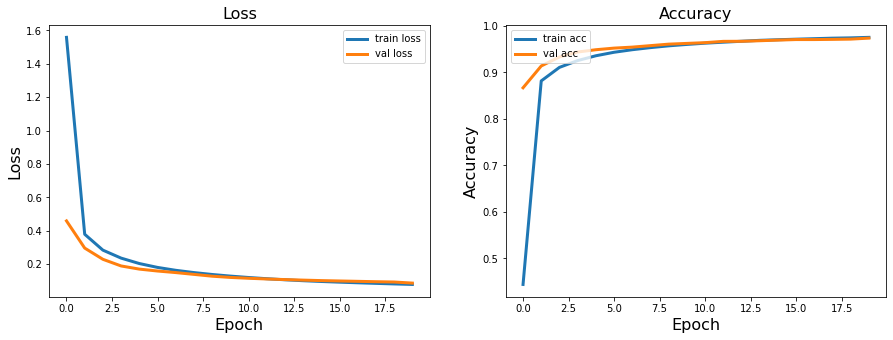

In [80]:
display_metrics(history)

#### Evaluating the custom CNN

In [24]:
MODEL_NAME = 'Custom_LeNet-5'

##### Initialising the model

In [74]:
### Creating the model instance

In [108]:
IMG_SHAPE_PADDED[1:3]

(32, 32)

In [191]:
model = create_custom_network(
            input_shape=(32, 32),
            output_shape=model_params[DATASET_NAME]['n_classes'],
            model_name=MODEL_NAME
)

In [192]:
### Defining the model hyperparameters

In [193]:
EPOCHS = 40

In [194]:
model_params[MODEL_NAME].update({'epochs': EPOCHS})
model_params[MODEL_NAME].update({'batch_size': BATCH_SIZE})
model_params[MODEL_NAME].update({'shuffle': True})

In [195]:
### Configuring the model for training

In [196]:
model.compile(
        optimizer=model_params[MODEL_NAME]['optimizer'],
        loss=model_params[MODEL_NAME]['loss_fn'],
        metrics=model_params[MODEL_NAME]['metrics']
)

In [197]:
model.build((None, 32, 32))

In [198]:
model.summary()

Model: "Custom_LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 R0 (Reshape)                (None, 32, 32)            0         
                                                                 
 Rs0 (Rescaling)             (None, 32, 32)            0         
                                                                 
 C1 (Conv1D)                 (None, 28, 60)            9660      
                                                                 
 C2 (Conv1D)                 (None, 24, 60)            18060     
                                                                 
 Bn3 (BatchNormalization)    (None, 24, 60)            240       
                                                                 
 M4 (MaxPooling1D)           (None, 12, 60)            0         
                                                                 
 C5 (Conv1D)                 (None, 10, 30)         

##### Performing training and validation loops

In [101]:
logger = get_module_logger(MODEL_NAME)

In [103]:
logger.info(f"\nTraining for {model_params[MODEL_NAME]['epochs']} epochs " + 
            f"using '{DATASET_NAME}' data")

2022-09-18 03:44:11,408 INFO     
Training for 40 epochs using 'MNIST' data
2022-09-18 03:44:11,408 INFO     
Training for 40 epochs using 'MNIST' data


In [104]:
### Usage of the `fit()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [205]:
train_data = digits_data[0].map(lambda x: tf.reshape(x['image'], (-1, 28, 28)))
val_data = digits_data[1].map(lambda x: tf.reshape(x['image'], (-1, 28, 28)))

In [206]:
train_labels = digits_data[0].map(lambda x: x['label'])
val_labels = digits_data[1].map(lambda x: x['label'])

In [207]:
train_dataset = tf.data.Dataset.zip((train_data, train_labels))
val_dataset = tf.data.Dataset.zip((val_data, val_labels))

In [ ]:
history = model.fit(
                x=train_dataset,
                epochs=model_params[MODEL_NAME].get('epochs', 10),
                batch_size=model_params[MODEL_NAME].get('batch_size', 128),
                validation_data=val_dataset,
                shuffle=True
)

##### Visualising the results

In [ ]:
display_metrics(history)

### 2.3 Evaluation on the GTSRB dataset

#### Considerations for our input data

In [26]:
DATASET_NAME = 'GTSRB'

In [27]:
N_CLASSES = 43                                    # GTSRB has 43 distinct digit classes

In [28]:
### Defining our input image specs

In [29]:
IMG_DIR = os.path.join(DIR_SRC, 'GTSRB/Final_Training/Images')

In [30]:
BATCH_SIZE = 20

In [31]:
IMG_COLOR_MODE = 'rgb'
IMG_SIZE = (32, 32)                               # Each RGB image has 32x32 px resolution
IMG_SHAPE = (32, 32, 3)                           # Each RGB image has 3 channels
N_FEATURES = (32 * 32) * 3                        # Each pixel value is considered an attribute (feature)

In [32]:
model_params[DATASET_NAME].update({'n_classes': N_CLASSES})
model_params[DATASET_NAME].update({'imdir': IMG_DIR})
model_params[DATASET_NAME].update({'batch_size': BATCH_SIZE})
model_params[DATASET_NAME].update({'color_mode': IMG_COLOR_MODE})
model_params[DATASET_NAME].update({'image_size': IMG_SIZE})
model_params[DATASET_NAME].update({'input_shape': IMG_SHAPE})
model_params[DATASET_NAME].update({'n_features': N_FEATURES})

#### Fetching the GTSRB data

In [33]:
def get_datasets(model_params: dict) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """Return the training and validation datasets.
    
    :param model_params: the dict containing the dataset- and 
        model-specific arguments.
    :returns: (train_dataset, validation_dataset), tuple of tf.data.Dataset 
        instances.
    """
    
    model_params = dict(model_params)
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                        directory=model_params.get('imdir', None),
                        labels='inferred',
                        label_mode='int',
                        color_mode=model_params.get('color_mode', None),
                        batch_size=model_params.get('batch_size', None),
                        image_size=model_params.get('image_size', None),
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='training',
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                        directory=model_params.get('imdir', None),
                        labels='inferred',
                        label_mode='int',
                        color_mode=model_params.get('color_mode', None),
                        batch_size=model_params.get('batch_size', None),
                        image_size=model_params.get('image_size', None),
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='validation',
    )
    return train_dataset, validation_dataset

In [34]:
### Fetching the training and validation datasets
train_dataset, validation_dataset = get_datasets(model_params[DATASET_NAME])

Found 4300 files belonging to 43 classes.
Using 3870 files for training.
Found 4300 files belonging to 43 classes.
Using 430 files for validation.


#### Processing the image data

In [158]:
### Number of features (pixel values) in a single image
train_iter = iter(train_dataset)
len(train_iter.get_next()[0][0].numpy().flatten())

3072

##### Using a generator function

In [35]:
### From J. Moran's `2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb`

In [36]:
def process(dataset: tf.data.Dataset) -> Generator[tuple, None, None]:
    """Processes the input dataset and returns a generator object.

    :param dataset: the tf.data.Dataset instance of batched image, label data.
    :returns: the generator instance modifying the image attribute values.
    """

    def process_generator()  -> Iterator[Tuple[tf.Tensor, tf.Tensor]]:
        """Scales the input image data.
        
        Unbatches the tf.data.Dataset and scales all image attributes,
        i.e., pixel values, in the range [0, 1].

        :returns: an iterator yielding the modfied image data and
            corresponding label.
        """

        for batch in dataset:
            for image, label in zip(*batch):
                image = tf.cast(image/255., tf.float32)
                yield image, label
    return process_generator

In [37]:
### Unbatching the datasets and scaling the images

In [38]:
train_dataset_scaled = tf.data.Dataset.from_generator(
        generator=process(train_dataset), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape', None),
                dtype=tf.dtypes.float32), 
            tf.TensorSpec(
                shape=(),
                dtype=tf.dtypes.int32)
        )
)

In [39]:
validation_dataset_scaled = tf.data.Dataset.from_generator(
        generator=process(validation_dataset), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape', None),
                dtype=tf.dtypes.float32), 
            tf.TensorSpec(
                shape=(),
                dtype=tf.dtypes.int32)
        )
)

In [142]:
type(validation_dataset_scaled)

tensorflow.python.data.ops.dataset_ops.FlatMapDataset

##### Using TensorFlow data operations

In [159]:
def process(image, label):
    """Scales the input image data."""
    
    image = tf.cast(image / 255., dtype=tf.dtypes.float32)
    return image, label

In [160]:
### Fetching the labels in the dataset
train_dataset_processed = train_dataset.map(process,
                                num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset_processed = validation_dataset.map(process,
                                num_parallel_calls=tf.data.AUTOTUNE
)

#### Evaluating the LeNet-5

##### Initialising the model

In [161]:
MODEL_NAME = 'LeNet-5'

In [162]:
### Creating the model instance

In [163]:
model = create_lenet_network(
            input_shape=model_params[DATASET_NAME]['input_shape'],
            output_shape=model_params[DATASET_NAME]['n_classes']
)

In [164]:
model.summary()

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 28, 28, 6)         456       
                                                                 
 S2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 Sigmoid_1 (Activation)      (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 S4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 Sigmoid_2 (Activation)      (None, 5, 5, 16)          0         
                                                                 
 C5 (Conv2D)                 (None, 1, 1, 120)         4812

##### Performing the training and validation loops

In [165]:
### Defining the model hyperparameters

In [166]:
EPOCHS = 200

In [167]:
model_params[MODEL_NAME].update({'epochs': EPOCHS})
model_params[MODEL_NAME].update({'batch_size': BATCH_SIZE})
model_params[MODEL_NAME].update({'shuffle': True})

In [168]:
### Configuring the model for training

In [169]:
model.compile(
        optimizer=model_params[MODEL_NAME]['optimizer'],
        loss=model_params[MODEL_NAME]['loss_fn'],
        metrics=model_params[MODEL_NAME]['metrics']
)

In [170]:
### From Udacity's `training.py`

In [171]:
logger.info(f"\nTraining for {model_params[MODEL_NAME]['epochs']} epochs " + 
            f"using '{model_params[DATASET_NAME]['imdir']}' data")

2022-09-18 00:29:05,619 INFO     
Training for 200 epochs using '/content/data/GTSRB/Final_Training/Images' data


In [172]:
### Usage of the `fit()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
history = model.fit(
                x=train_dataset_processed,
                epochs=model_params[MODEL_NAME].get('epochs', 10),
                batch_size=model_params[MODEL_NAME].get('batch_size', 128),
                validation_data=val_dataset_processed,
                shuffle=True
)

In [95]:
### Usage of the `callbacks()` method
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [96]:
type(history)

keras.callbacks.History

##### Visualising the results

In [97]:
### From Udacity's `training.py`

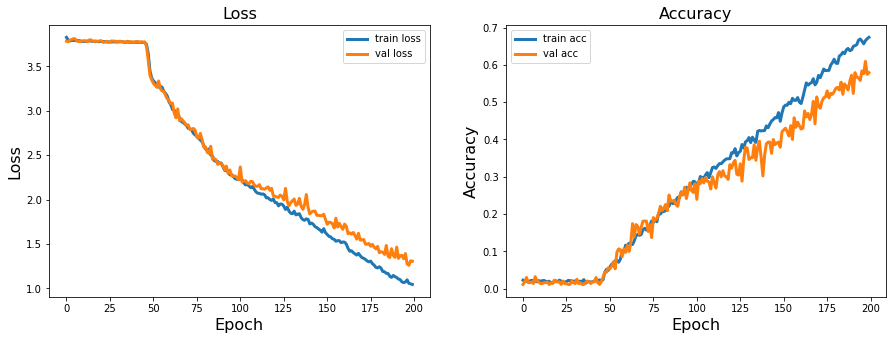

In [98]:
display_metrics(history)

#### Evaluating the custom CNN

In [35]:
MODEL_NAME = 'Custom_LeNet-5'

##### Initialising the model

In [36]:
### Creating the model instance

In [37]:
model = create_custom_network(
            input_shape=model_params[DATASET_NAME]['input_shape'][:2],
            output_shape=model_params[DATASET_NAME]['n_classes'],
            model_name=MODEL_NAME
)

##### Additional GTSRB preprocessing

In [38]:
### Convert all RGB images to grayscale

In [39]:
def rgb_to_grayscale(images: tf.Tensor, labels: tf.Tensor) -> tf.Tensor:
    """Converts RGB input tensor to grayscale."""

    return tf.image.rgb_to_grayscale(images), labels

In [40]:
train_dataset_gray = train_dataset.map(rgb_to_grayscale)
validation_dataset_gray = validation_dataset.map(rgb_to_grayscale)

In [41]:
### Previewing a single training image (converted to grayscale)

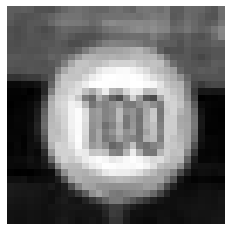

In [44]:
plt.figure()
plt.imshow(tf.squeeze(iter(train_dataset_gray).get_next()[0][0], axis=-1), 
           cmap='gray')
plt.axis('off')
plt.show()

##### Performing the training and validation loops

In [45]:
### Defining the model hyperparameters

In [53]:
EPOCHS = 40

In [54]:
model_params[MODEL_NAME].update({'epochs': EPOCHS})
model_params[MODEL_NAME].update({'batch_size': BATCH_SIZE})
model_params[MODEL_NAME].update({'shuffle': True})

In [55]:
### Configuring the model for training

In [56]:
model.compile(
        optimizer=model_params[MODEL_NAME]['optimizer'],
        loss=model_params[MODEL_NAME]['loss_fn'],
        metrics=model_params[MODEL_NAME]['metrics']
)

In [57]:
model.build((None, *model_params[DATASET_NAME]['input_shape'][:2]))

In [58]:
model.summary()

Model: "Custom_LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 R0 (Reshape)                (None, 32, 32)            0         
                                                                 
 Rs0 (Rescaling)             (None, 32, 32)            0         
                                                                 
 C1 (Conv1D)                 (None, 28, 60)            9660      
                                                                 
 C2 (Conv1D)                 (None, 24, 60)            18060     
                                                                 
 Bn3 (BatchNormalization)    (None, 24, 60)            240       
                                                                 
 M4 (MaxPooling1D)           (None, 12, 60)            0         
                                                                 
 C5 (Conv1D)                 (None, 10, 30)         

**Note**: since we moved the resizing/rescaling functions inside the model, we will be running the training loop over the otherwise raw grayscale GTSRB images. 

In [59]:
logger.info(f"\nTraining for {model_params[MODEL_NAME]['epochs']} epochs " + 
            f"using '{model_params[DATASET_NAME]['imdir']}' data")

2022-09-18 03:14:17,070 INFO     
Training for 40 epochs using '/content/data/GTSRB/Final_Training/Images' data


In [60]:
### Usage of the `fit()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [61]:
history = model.fit(
                x=train_dataset_gray,
                epochs=model_params[MODEL_NAME].get('epochs', 10),
                batch_size=model_params[MODEL_NAME].get('batch_size', 128),
                validation_data=validation_dataset_gray,
                shuffle=True
)

Epoch 1/40
194/194 [==============================] - 8s 26ms/step - loss: 4.6099 - accuracy: 0.0403 - val_loss: 3.6872 - val_accuracy: 0.0512
Epoch 2/40
194/194 [==============================] - 5s 25ms/step - loss: 3.9429 - accuracy: 0.0832 - val_loss: 3.1460 - val_accuracy: 0.1674
Epoch 3/40
194/194 [==============================] - 4s 22ms/step - loss: 2.9982 - accuracy: 0.2096 - val_loss: 2.2138 - val_accuracy: 0.4140
Epoch 4/40
194/194 [==============================] - 4s 22ms/step - loss: 2.2575 - accuracy: 0.3638 - val_loss: 1.7223 - val_accuracy: 0.5791
Epoch 5/40
194/194 [==============================] - 4s 22ms/step - loss: 1.8117 - accuracy: 0.4783 - val_loss: 1.1396 - val_accuracy: 0.6651
Epoch 6/40
194/194 [==============================] - 4s 22ms/step - loss: 1.5063 - accuracy: 0.5483 - val_loss: 0.9002 - val_accuracy: 0.7628
Epoch 7/40
194/194 [==============================] - 5s 24ms/step - loss: 1.2751 - accuracy: 0.6098 - val_loss: 0.7918 - val_accuracy: 0.7651

##### Visualising the results

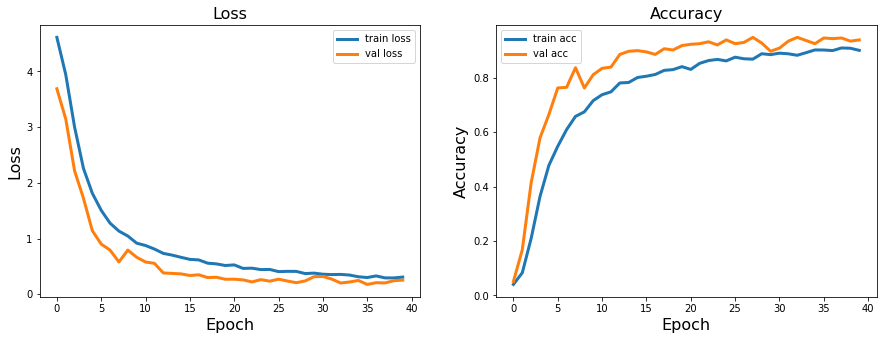

In [62]:
display_metrics(history)

## Tips

A good starting point for small networks is LeNet5. You will find many existing implementations online.

Don't forget the basic structure of a convnet: convolutional layer, activation and pooling.

You can use the [`summary`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) method of the Keras model API to print the description of your model.

## Credits

This assignment was prepared by Thomas Hossler et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).


References

[1] Yu, F. Vladlen, K. Multi-Scale Context Aggregation by Dialated Convolutions. ArXiv. 2015. [doi:10.48550/ARXIV.1511.07122](https://arxiv.org/abs/1511.07122).

[2] LeCun, Y. et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, 1998. [doi:10.1109/5.726791](https://ieeexplore.ieee.org/document/726791).


[3] Glorot, X. et al. Deep Sparse Rectifier Neural Networks. Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics, PMLR 15:315-323, 2011. [https://proceedings.mlr.press/v15/glorot11a.html](https://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf).

[4] Zaibi, A. et al. A Lightweight Model for Traffic Sign Classification Based on Enhanced LeNet-5 Network. Journal of Sensors, vol. 2021. 2021. [doi:10.1155/2021/8870529](https://doi.org/10.1155/2021/8870529).


Helpful resources:
* [Convolutional Neural Network: An Overview by S. Shah | Analytics Vidhya](https://www.analyticsvidhya.com/blog/2022/01/convolutional-neural-network-an-overview/)
* [Understanding the receptive field of deep convolutional networks by N. Adaloglou | AI Summer](https://theaisummer.com/receptive-field/)
* [The Dying ReLU Problem, Clearly Explained by K. Leung | Towards Data Science](https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24)
* [What is the dying ReLU problem? by S. Azhar | Educative.io](https://www.educative.io/answers/what-is-the-dying-relu-problem)